<a href="https://colab.research.google.com/github/CoderSsVartak/Image-Reconstruction/blob/master/image_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import random
import datetime
import pytz

#Image manipulation packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

#Tensorflow models libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Conv2DTranspose, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
#Alternative of pickle for larger files
import joblib
import pickle

#packages required to get the data uploaded on the drive
from googleapiclient.http import MediaIoBaseDownload
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import drive
import io
import random

In [ ]:
# Google Drive API Code to authenticate access
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Code to load images from Drive
def load_drive_data(file_id):

    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)

    # Joblib is used because of large file size
    f = joblib.load(downloaded)

    return f

#images downloaded are in the form of a dictionary, convert it to a numpy array
def dict_to_array(images):

    image_list = []
    for persons in images.keys():
        image_list.append(images[persons])
    
    return np.array(image_list)

#function to plot multiple images
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(image.shape[0], image.shape[1], image.shape[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [ ]:
#images obtained are in the form of a dictionary and have values between 0-1, and are cropped so as to obtain just the facial images
#dictionary[person] = image_value

# Data description: Total facial images of 105 people with each person having a total of 6 images
# Input given is the file id of the file stored in drive
image_data = load_drive_data('1QZv7mWvvF8mnT0A2mA4OFSvxF1eqPd8g')
images = dict_to_array(image_data)

# Create data copy to local storage, can be accessed directly from there
# with open('image_data.pickle', 'wb') as file:
    # joblib.dump(images, file)

# Load the test set images required
# with open('/content/image_data.pickle', 'rb') as file:
#     images = joblib.load(file)

In [ ]:
del (image_data)
images.shape

(630, 224, 224, 3)

In [ ]:
# Block a % of image visible
# percent_mask is in the range 0 - 1
def create_masked_images(images, **kwargs):

    mask_shape = images.shape

    # default value for percentage of image to be masked
    percent_mask = 0.5
    if 'percent_mask' in kwargs:
        percent_mask = kwargs['percent_mask']

    # hide_axis = 2 => row axis
    hide_axis = 2
    if 'hide_axis' in kwargs:
        hide_axis = kwargs['hide_axis']
    
    # Always the 2nd axis ie columns are masked
    zero_shape = int(mask_shape[hide_axis]*percent_mask)//2
    one_shape = mask_shape[hide_axis] - zero_shape*2

    if 'partial_image' in kwargs:

        print("Hidden pixels and Visible Pixels Count: ",zero_shape, one_shape)
        # print(images[:, :, zero_shape: one_shape+zero_shape, :].shape)
        return images[:, :, zero_shape: one_shape+zero_shape, :]
    
    if hide_axis == 1:
        zero_shape = (mask_shape[0], zero_shape, mask_shape[2], mask_shape[3])
        one_shape = (mask_shape[0], one_shape, mask_shape[2], mask_shape[3])
    
    else:
        zero_shape = (mask_shape[0], mask_shape[1], zero_shape, mask_shape[3])
        one_shape = (mask_shape[0], mask_shape[1], one_shape, mask_shape[3])

    print(zero_shape, one_shape)
    mask = np.concatenate((np.zeros(zero_shape), np.ones(one_shape), np.zeros(zero_shape)), axis=hide_axis)

    if 'show_boundary' in kwargs and kwargs['show_boundary']:
        mask_compliment = 1 - mask
        return mask*images + np.mean(images)*mask_compliment

    return mask*images


(5, 224, 67, 3) (5, 224, 90, 3)


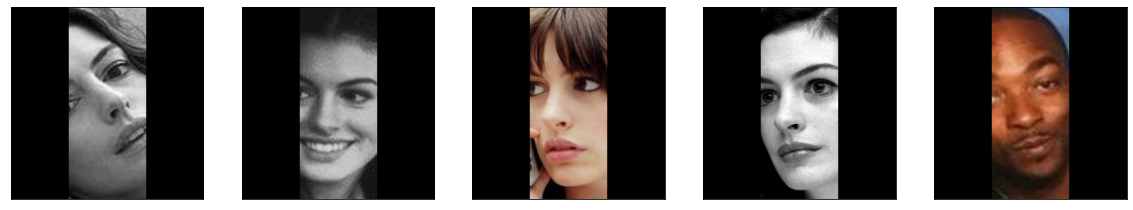

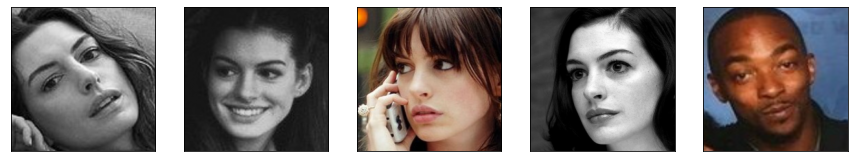

In [ ]:
plot(create_masked_images(images[50: 55], percent_mask = 0.6, hide_axis=2), figsize=(20, 20))
plot(images[50: 55], figsize=(15, 15))

In [ ]:
# Initially 60% image is masked, 530 for training and 100 for testing.
# Reduce masking size if network doesnt optimize

In [ ]:
masked_images = create_masked_images(images, percent_mask = 0.6, hide_axis=2)

(630, 224, 67, 3) (630, 224, 90, 3)


In [ ]:
masked_images.shape

(630, 224, 224, 3)

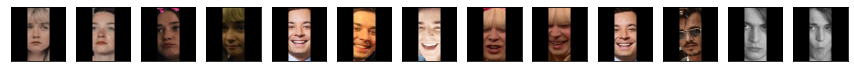

In [ ]:
start, end = 290, 303
plot(masked_images[start: end], figsize=(15, 15))

In [ ]:
def image_generator(image_shape):

    input_img = Input(shape=image_shape, dtype='float32')

    x = Conv2D(64, (5, 5), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(input_img)
    x = Conv2D(128, (3, 3), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(2, 2), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(4, 4), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(8, 8), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    x = Conv2D(3, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)

    return Model(input_img, x, name='Generator')


def image_discriminator(image_shape):

    input_img = Input(shape=image_shape, dtype='float32')

    x = Conv2D(32, (5, 5), strides=2, activation='relu', padding='same')(input_img)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(input_img, x, name='Discriminator')


    

In [ ]:
gen_model = image_generator((224, 224, 3))
gen_model.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 224, 224, 64)      4864      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 112, 112, 256)     295168    
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 112, 112, 256)     590080    
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 112, 112, 256)     590080    
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 112, 112, 256)     59

In [ ]:
disc_model = image_discriminator(image_shape=(224, 224, 3))
disc_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 112, 112, 32)      2432      
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 56, 56, 64)        51264     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 14, 14, 64)        102464    
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 7, 64)          102464    
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)            

In [ ]:
# Loss functions

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred))

# y_true is the output of the discriminator for actual images
# y_pred is the output of the discriminator for generator generated images

def discriminator_loss(y_true, y_pred, epsilon=1e-5):
    return tf.reduce_mean(tf.math.log(tf.maximum(y_true, epsilon)) + tf.math.log(tf.maximum(1-y_pred, epsilon)))


# y_true is the actual image
# y_pred is the generated image
# discriminator_pred is the output of the discriminator when given image generated by the generator
# alpha is used as a control variable to determine the importance of mse loss
# mask == mask_compliment
def generator_loss(y_true, y_pred, discriminator_pred, mask, alpha=0.0001):
    return mask*mse(y_true, y_pred) - alpha*tf.reduce_mean(tf.math.log(discriminator_pred))


#Tensorflow function to find psnr of an image

def psnr(y_true, y_pred):
    return tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1, name=None))

In [ ]:
# Common parameters for generator and discriminator

metrics = [tf.metrics.RootMeanSquaredError, psnr]
batch_size = 64
epochs = 100
learning_rate = 0.0004
epsilon = 1e-9
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

gen_loss = generator_loss
disc_loss = discriminator_loss

In [ ]:
# https://keras.io/guides/writing_a_training_loop_from_scratch/